In [ ]:
import pandas as pd
import numpy as np 
import csv as csv
import matplotlib.pyplot as plt
import random
import json
import math

from scipy.stats import poisson
from sklearn.cluster import DBSCAN

import geopandas as gpd
import pyproj
from pyproj import Proj, transform, CRS
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

import re
from tqdm import tqdm

# Bevölkerungsdaten - Zensus Transformation

In [ ]:
file_path = './Einwohner_Data/Bevoelkerung100M.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1', delimiter=';')

In [ ]:
list_of_merkmale = [' INSGESAMT', 'ALTER_KURZ', 'GESCHLECHT', 'ALTER_10JG']
df_einwohner = df[df['Merkmal'].isin(list_of_merkmale)]

df_bezeichnungen = pd.DataFrame()
bezeichnungen = ['Merkmal', 'Auspraegung_Text', 'Auspraegung_Code']
df_bezeichnungen = df_einwohner[bezeichnungen]
df_bezeichnungen.drop_duplicates(inplace=True)
df_bezeichnungen.sort_values(by=['Merkmal', 'Auspraegung_Code'], inplace=True)
df_bezeichnungen.reset_index(drop=True, inplace=True)
df_bezeichnungen.to_csv('./Einwohner_Data/Bezeichnungen.csv', index=False)

df_einwohner['Attribute'] = df_einwohner['Merkmal'] + '_' + df_einwohner['Auspraegung_Code'].astype(str)
df_einwohner.drop(columns=['Merkmal', 'Auspraegung_Code', 'Auspraegung_Text', 'Gitter_ID_100m', 'Anzahl_q'], inplace=True)

In [ ]:
pivot_df = df_einwohner.pivot(index=['Gitter_ID_100m_neu'], columns=['Attribute'], values='Anzahl').reset_index()
pivot_df.columns.name = None
pivot_df = pivot_df.fillna(0)
pivot_df.rename(columns={' INSGESAMT_0': 'INSGESAMT_0'}, inplace=True)
pivot_df.to_csv('./Einwohner_Data/Einwohner_Cleaned.csv')

In [ ]:
df_geo = pd.read_csv('./Einwohner_Data/Einwohner_Cleaned.csv')
# Extrahiere Informationen aus der Gitter-IDs mithilfe von regulären Ausdrücken
pattern = re.compile(r'N(\d+)E(\d+)')
df_geo[['origin_n', 'origin_e']] = df_geo['Gitter_ID_100m_neu'].str.extract(pattern).astype(int)

# Setze feste Werte für crs_code und resolution 
df_geo['crs_code'] = 3035
df_geo['resolution'] = 100

# Erstelle Geometrien (Quadrate) für jedes Gitter
df_geo['geometry'] = [Polygon([(e, n), (e + 100, n), (e + 100, n - 100), (e, n - 100)]) for e, n in zip(df_geo['origin_e'], df_geo['origin_n'])]
df_geo.to_csv('./GeoDaten/GeoDataFrame_Bevoelkerung.csv')

In [ ]:
gdf = gpd.GeoDataFrame(df_geo, geometry='geometry', crs=CRS(f"EPSG:{df_geo['crs_code'].iloc[0]}"))
gdf.to_file('./GeoDaten/Deutschland_Raster.gpkg', driver='GPKG')

In [ ]:
vmin, vmax = 0, 20
# Plotte das GeoDataFrame mit Farbhervorhebung der 'INSGESAMT'-Werte und angepasster Skala
gdf.plot(column='INSGESAMT_0', cmap='viridis', legend=True, figsize=(10, 10), vmin=vmin, vmax=vmax)
plt.title('Farbliche Hervorhebung der INSGESAMT-Werte')
plt.show()

# Laden der Verwaltungsbezirke um die Raster zu filtern

In [12]:
gdf = gpd.read_file('./GeoDaten/Deutschland_Raster_Bevoelkerung.gpkg')

In [ ]:
geo_bundesländer = gpd.read_file('./GeoDaten/DE_NUTS5000.gpkg')
geo_würzburg = geo_bundesländer[geo_bundesländer['NUTS_NAME'].str.contains('Würzburg')]
geo_würzburg = geo_würzburg.to_crs(gdf.crs)
geo_würzburg.to_file('./Wuerzburg_Data/feo_wuerzburg.gpkg', driver = 'GPKG')
mask_overlapping = gdf.geometry.intersects(geo_würzburg.unary_union)
gdf_würzburg = gdf[mask_overlapping]
gdf_würzburg.to_file('./Wuerzburg_Data/Raster_Wuerzburg.gpkg', driver='GPKG')

In [13]:
geo_bundesländer = gpd.read_file('./GeoDaten/DE_NUTS5000.gpkg')
geo_frankfurt = geo_bundesländer[geo_bundesländer['NUTS_NAME'].str.contains('Frankfurt am Main')]
geo_frankfurt = geo_frankfurt.to_crs('3035')
geo_frankfurt.to_file('./Frankfurt_Data/geo_frankfurt.gpkg', driver = 'GPKG')
mask_overlapping = gdf.geometry.intersects(geo_frankfurt.unary_union)
gdf_frankfurt = gdf[mask_overlapping]
gdf_frankfurt.to_file('./Frankfurt_Data/Raster_Frankfurt.gpkg', driver='GPKG')

In [17]:
geo_bundesländer = gpd.read_file('./GeoDaten/DE_NUTS5000.gpkg')
geo_donner = geo_bundesländer[geo_bundesländer['NUTS_NAME'].str.contains('Donnersbergkreis')]
geo_donner = geo_donner.to_crs('3035')
geo_donner.to_file('./Donner_Data/geo_donner.gpkg', driver = 'GPKG')
mask_overlapping = gdf.geometry.intersects(geo_donner.unary_union)
gdf_donner = gdf[mask_overlapping]
gdf_donner.to_file('./Donner_Data/Raster_Donner.gpkg', driver='GPKG')

# Gebäudedaten und Bevölkerungsdaten mappen

In [34]:
df_buildings = pd.read_csv('./Donner_Data/Donner-Buildings.csv')
gdf_würzburg = gpd.read_file('./Donner_Data/Raster_Donner.gpkg')

## Gebäude einem Raster zuordnen

In [35]:
def find_nearest_polygon_id(point, polygons):
    return polygons.distance(point.geometry).sort_values().index[0] 

In [36]:
gdf_buildings = gpd.GeoDataFrame(df_buildings, geometry=gpd.points_from_xy(df_buildings['lon'], df_buildings['lat']), crs=CRS("EPSG:4326"))
gdf_buildings = gdf_buildings.to_crs(gdf_würzburg.crs)
df_buildings['Raster_ID'] = -1

for index, building in gdf_buildings.iterrows():

    mask_overlapping = gdf_würzburg.intersects(building['geometry'])
    
    if any(mask_overlapping):
        df_buildings.loc[index, 'Raster_ID'] = gdf_würzburg[mask_overlapping].index[0]
    else:
        df_buildings.loc[index, 'Raster_ID'] = find_nearest_polygon_id(building, gdf_würzburg)


gdf_buildings_with_raster = gpd.GeoDataFrame(df_buildings, geometry=gdf_buildings['geometry'], crs=gdf_würzburg.crs)

In [37]:
# Zähle die eindeutigen Werte in der Spalte 'Spalte_Name'
value_counts = gdf_buildings_with_raster['Raster_ID'].value_counts()

# Sortiere die Ergebnisse nach den Werten
sorted_value_counts = value_counts.sort_values(ascending = False)

# Gib die sortierten Ergebnisse aus
print("Sortierte Wertezählungen:")
print(sorted_value_counts)

Sortierte Wertezählungen:
Raster_ID
3540    103
3247    101
3905     82
3068     63
2659     59
       ... 
1049      1
151       1
164       1
334       1
2533      1
Name: count, Length: 3457, dtype: int64


## Jedem Gebäude die Bevölkerung zuweisen

In [38]:
gdf_buildings_with_raster['Einwohner'] = 0
gdf_buildings_with_raster['Alter'] = {} 
gdf_buildings_with_raster['Geschlecht'] = {} 


unique_raster_indices = gdf_buildings_with_raster['Raster_ID'].unique()

for raster_index in unique_raster_indices:
    einwohner_aus_raster = gdf_würzburg.at[raster_index, 'INSGESAMT_0']

    alter_dict_raster = {
            '0-10':  int(gdf_würzburg.at[raster_index, 'ALTER_10JG_1']),
            '10-20': int(gdf_würzburg.at[raster_index, 'ALTER_10JG_2']),
            '20-30': int(gdf_würzburg.at[raster_index, 'ALTER_10JG_3']),
            '30-40': int(gdf_würzburg.at[raster_index, 'ALTER_10JG_4']), 
            '40-50': int(gdf_würzburg.at[raster_index, 'ALTER_10JG_5']), 
            '50-60': int(gdf_würzburg.at[raster_index, 'ALTER_10JG_6']),
            '60-70': int(gdf_würzburg.at[raster_index, 'ALTER_10JG_7']), 
            '70-80': int(gdf_würzburg.at[raster_index, 'ALTER_10JG_8']),
            '80+':   int(gdf_würzburg.at[raster_index, 'ALTER_10JG_9'])
        }
    
    geschlecht_dict_raster = {
            'maennlich': gdf_würzburg.at[raster_index, 'GESCHLECHT_1'],
            'weiblich':  gdf_würzburg.at[raster_index, 'GESCHLECHT_2']
        }
   
    for index, building in gdf_buildings_with_raster[gdf_buildings_with_raster['Raster_ID'] == raster_index].iterrows():

        alter_dict_geb = {
            '0-10': 0,
            '10-20': 0,
            '20-30': 0,
            '30-40': 0, 
            '40-50': 0, 
            '50-60': 0,
            '60-70': 0, 
            '70-80': 0,
            '80+': 0
        }

        geschlecht_dict_geb = {
            'maennlich': 0,
            'weiblich': 0
        }


        if index == gdf_buildings_with_raster[gdf_buildings_with_raster['Raster_ID'] == raster_index].index.max():
            random_einwohner = einwohner_aus_raster
        else:
            random_einwohner = np.random.choice(int(einwohner_aus_raster))

        
        random_einwohner = int(random_einwohner)
        alter_count = random_einwohner
        geschlecht_count = random_einwohner

        for key in np.random.permutation(list(alter_dict_raster.keys())):
            if alter_count == 0:
                break
            if alter_dict_raster[key] > 0:
                if alter_count <= alter_dict_raster[key]:
                    alter_dict_geb[key] = alter_count
                    alter_dict_raster[key] -= alter_count
                    alter_count = 0

                else:
                    alter_dict_geb[key] = alter_dict_raster[key]
                    alter_count -= alter_dict_raster[key]
                    alter_dict_raster[key] = 0
        

        if alter_count != 0:
            alter_dict_geb[random.choice(list(alter_dict_geb.keys()))] += alter_count
            


        for key in np.random.permutation(list(geschlecht_dict_raster.keys())):
            if geschlecht_count == 0:
                break
            if geschlecht_dict_raster[key] > 0:
                if geschlecht_count <= geschlecht_dict_raster[key]:
                    geschlecht_dict_geb[key] = geschlecht_count
                    geschlecht_dict_raster[key] -= geschlecht_count
                    geschlecht_count = 0

                else:
                    geschlecht_dict_geb[key] = geschlecht_dict_raster[key]
                    geschlecht_count -= geschlecht_dict_raster[key]
                    geschlecht_dict_raster[key] = 0


        if geschlecht_count != 0:
            geschlecht_dict_geb[random.choice(list(geschlecht_dict_geb.keys()))] += geschlecht_count


        gdf_buildings_with_raster.at[index, 'Einwohner'] = random_einwohner
        gdf_buildings_with_raster.loc[index, 'Alter'] = [alter_dict_geb]
        gdf_buildings_with_raster.loc[index, 'Geschlecht'] = [geschlecht_dict_geb]
        einwohner_aus_raster -= random_einwohner

In [39]:
gdf_buildings_with_raster['Alter'] = gdf_buildings_with_raster['Alter'].apply(json.dumps)
gdf_buildings_with_raster['Geschlecht'] = gdf_buildings_with_raster['Geschlecht'].apply(json.dumps)

gdf_buildings_with_raster.to_file('./Donner_Data/Buildings_Raster_Demographie.gpkg', driver='GPKG')

# Pharmacy allocation to each building

In [41]:
columns_to_drop = ['name', 'building', 'addr:street', 'addr:housenumber', 'addr:postcode']
bevölkerungs_gdf = gpd.read_file('./Donner_Data/Buildings_Raster_Demographie.gpkg')
bevölkerungs_gdf['Alter'] = bevölkerungs_gdf['Alter'].apply(json.loads)
bevölkerungs_gdf['Geschlecht'] = bevölkerungs_gdf['Geschlecht'].apply(json.loads)
bevölkerungs_gdf.drop(columns=columns_to_drop, inplace=True)

pharmacy_df = pd.read_csv('./Donner_Data/Donner-Apotheken.csv')
pharmacy_gdf = gpd.GeoDataFrame(pharmacy_df, geometry=gpd.points_from_xy(pharmacy_df['lon'], pharmacy_df['lat']), crs=CRS("EPSG:4326"))
pharmacy_gdf = pharmacy_gdf.to_crs(bevölkerungs_gdf.crs)

In [42]:
def find_nearest_point_with_cKDTree(lon, lat, points_df):
  coordinates = np.array(points_df[['lon', 'lat']])
  reference_point = np.array([lon, lat])
  # Calculate pairwise squared distances (faster for cKDTree)
  distances = np.sum((coordinates - reference_point)**2, axis=1)
  # Find index of minimum distance
  idx = np.argmin(distances)

  return points_df.iloc[idx]  # Use iloc for faster integer indexing

In [43]:
def calculate_distance_to_nearest_pharmacy(row):
    nearest_pharmacy = find_nearest_point_with_cKDTree(row.lon, row.lat, pharmacy_gdf)
    return nearest_pharmacy['id']

In [44]:
bevölkerungs_gdf['assigned_pharmacy'] = 0 

tqdm.pandas()

# Iterate through rows
for index, row in tqdm(bevölkerungs_gdf.iterrows(), total=len(bevölkerungs_gdf)):
    pharmacy = calculate_distance_to_nearest_pharmacy(row)
    bevölkerungs_gdf.loc[index, 'assigned_pharmacy'] = pharmacy

100%|██████████| 44578/44578 [00:42<00:00, 1038.51it/s]


In [45]:
bevölkerungs_gdf['Alter'] = bevölkerungs_gdf['Alter'].apply(json.dumps)
bevölkerungs_gdf['Geschlecht'] = bevölkerungs_gdf['Geschlecht'].apply(json.dumps)
bevölkerungs_gdf.to_file('./Donner_Data/pharmacy_assigned.gpkg', driver='GPKG')

# Nachfrage-Wahrscheinlichkeitsverteilung

In [ ]:
# Frequent von Apothekenbesuchen nach Altersverteilung
"Mehrmals in der Woche, Etwa einmal in der Woche, Zwei- bis dreimal im Monat, Einmal im Monat, Etwa einmal im Vierteljahr, Seltener, Nie, so gut wie nie"
apotheken_besuch = {
    '14-19': [0.002, 0.005, 0.023, 0.053, 0.18, 0.305, 0.432],
    '20-29': [0.003, 0.009, 0.052, 0.131, 0.282, 0.326, 0.197],
    '30-39': [0.006, 0.013, 0.098, 0.198, 0.287, 0.275, 0.123],
    '40-49': [0.009, 0.014, 0.105, 0.21, 0.297, 0.258, 0.106],
    '50-59': [0.008, 0.019, 0.116, 0.252, 0.308, 0.209, 0.087],
    '60-69': [0.005, 0.037, 0.173, 0.277, 0.278, 0.159, 0.071],
    '70+':   [0.011, 0.065, 0.252, 0.336, 0.196, 0.064, 0.075]
}


# # Dauerhafte Einnahme von Medikamenten
# 'keine, ein bis zwei, drei, vier, fünf oder mehr'
# dauerhafte_einnahme = {
#     'Maenner': [0.51, 0.24, 0.08, 0.06, 0.11],
#     'Frauen':  [0.41, 0.35, 0.09, 0.06, 0.09],
#     '18-29':   [0.66, 0.30, 0.02, 0.01, 0.01],
#     '30-49':   [0.59, 0.31, 0.05, 0.02, 0.03],
#     '50-69':   [0.37, 0.31, 0.12, 0.08, 0.12],
#     '70+':     [0.22, 0.23, 0.16, 0.14, 0.25]
# }


In [ ]:
# Extrahieren der Spaltenwerte
alter_verteilung = {
    "10-20": 0,
    "20-30": 0,
    "30-40": 0,
    "40-50": 0,
    "50-60": 0,
    "60-70": 0,
    "70-80": 0
}


prob_werte = list(apotheken_besuch.values())
prob_arrays = np.stack(prob_werte)

keys = list(alter_verteilung.keys())

#p_Monat = 1 - (1 - p_Tag)^(Anzahl Tage im Monat)
#Mehrmals in der Woche, Etwa einmal in der Woche, Zwei- bis dreimal im Monat, Einmal im Monat
probabilities = []

for i in range(5):
    for j in range(7):  
        if i == 0:
            alter_verteilung[keys[j]] += prob_arrays[j][i] / 3.85714285714

        if i == 1:
            alter_verteilung[keys[j]] += prob_arrays[j][i] / 7

        if i == 2:
            alter_verteilung[keys[j]] += prob_arrays[j][i] / 12
            
        if i == 3:
            alter_verteilung[keys[j]] += prob_arrays[j][i] / 30

        if i == 4:
            alter_verteilung[keys[j]] += prob_arrays[j][i] / 90

alter_verteilung["10-20"] = alter_verteilung["10-20"] /2 

print(alter_verteilung)

# Transportkapazität

## Drohnenlogistik Unternehmen und Drohnenparameter

In [ ]:
# 5 größten Drohnenlogistik Unternehmen:
    # Drone Delivery Canada
    # Amazon.com, Inc.
    # Matternet
    # DHL
    # Zipline International Inc.

### Drone Delivery Canada

In [ ]:
# Sparrow
#     Max Range 20 km
#     Max Speed 60 km/h
#     Max Payload 4 kg
#     MTOW 25 kg
#     Aircraft Type Rotorcraft
#     Powerplant 8 Electric Motors
#     Navigation GPS-based
#     Delivery Options Land - Drop Ship

In [ ]:
# Canary
#     Max Range 20 km
#     Max Speed 72 km/h
#     Max Payload 4.5 kg
#     MTOW 25 kg
#     Aircraft Type Rotorcraft
#     Powerplant 8 Electric Motors
#     Navigation GPS-based
#     Delivery Options Land - Drop Ship

### Amazon.com, Inc.

In [ ]:
# Prime Air MK27-2
#     Max Range 25 km
#     Max Speed 80 km/h
#     Max Payload 2.26 kg
#     MTOW 25 kg
#     Max Altitude 122 m
#     Weather resistent

In [ ]:
# Prime Air MK30
#     ?

### Matternet

In [ ]:
# M2 Drone 
    # Max Range 20 km
    # Max Speed 50 km/h
    # Max Payload 2 kg
    # Max Altitude 120 m
    # MTOW 9.5 kg
    # Retail Price 7,499.00$
    # Aircraft type Quadcopter

### DHL

### Zipline International Inc.

In [ ]:
# P1
#   Max Range 193 km
#   Max Speed 105 km/h


In [ ]:
# P2


# Clustering der Rastereinheiten

In [62]:
gdf_wuerzburg = gpd.read_file('./Donner_Data/Raster_Donner.gpkg')

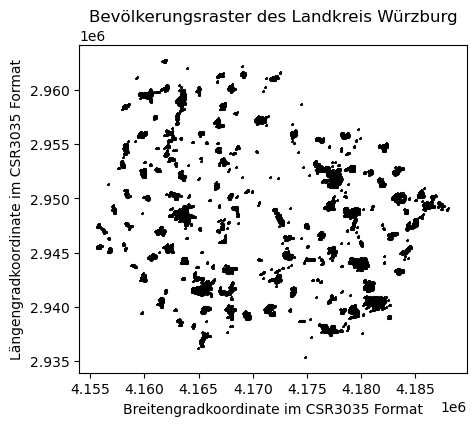

In [63]:
# Plot der Raster mit Polygone farblich darstellen
ax = gdf_wuerzburg.plot(cmap='viridis', legend=True, figsize=(5, 5))

# Hervorhebung der Rastergrenzen
gdf_wuerzburg.boundary.plot(ax=ax, color='black')

# Titel hinzufügen
plt.title('Bevölkerungsraster des Landkreis Würzburg')

# Achsenbeschriftungen hinzufügen
plt.xlabel('Breitengradkoordinate im CSR3035 Format')
plt.ylabel('Längengradkoordinate im CSR3035 Format')

plt.show()

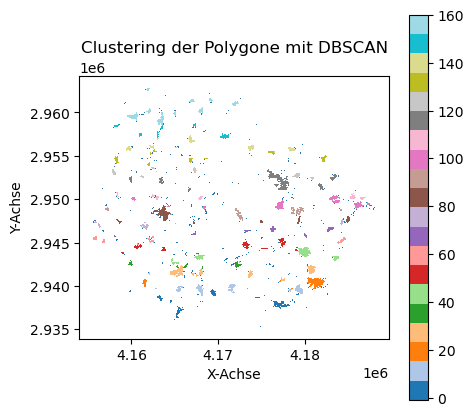

In [72]:
# Extrahieren der Polygon-Koordinaten als Features für das Clustering
X = np.array(gdf_wuerzburg.geometry.apply(lambda polygon: [polygon.centroid.x, polygon.centroid.y]).tolist())

# DBSCAN-Clustering durchführen
dbscan = DBSCAN(eps=100, min_samples=4)  # Anpassen von eps und min_samples je nach Bedarf
dbscan.fit(X)

# Fügen Sie die Cluster-Zuordnung als neue Spalte zum GeoDataFrame hinzu
gdf_wuerzburg['cluster'] = dbscan.labels_

# Plotten der Polygone mit Cluster-Färbung
ax = gdf_wuerzburg.plot(column='cluster', cmap='tab20', legend=True, figsize=(5, 5))
plt.title('Clustering der Polygone mit DBSCAN')
plt.xlabel('X-Achse')
plt.ylabel('Y-Achse')
plt.show()

In [73]:
# Alle eindeutigen Cluster-Werte und ihre Anzahl der Polygone ausgeben
cluster_counts = gdf_wuerzburg['cluster'].value_counts().sort_index()
print("Cluster-Werte und ihre Anzahl der Polygone:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} Polygone")

Cluster-Werte und ihre Anzahl der Polygone:
Cluster -1: 563 Polygone
Cluster 0: 4 Polygone
Cluster 1: 2 Polygone
Cluster 2: 34 Polygone
Cluster 3: 78 Polygone
Cluster 4: 4 Polygone
Cluster 5: 8 Polygone
Cluster 6: 20 Polygone
Cluster 7: 32 Polygone
Cluster 8: 54 Polygone
Cluster 9: 66 Polygone
Cluster 10: 4 Polygone
Cluster 11: 35 Polygone
Cluster 12: 48 Polygone
Cluster 13: 7 Polygone
Cluster 14: 4 Polygone
Cluster 15: 3 Polygone
Cluster 16: 4 Polygone
Cluster 17: 5 Polygone
Cluster 18: 160 Polygone
Cluster 19: 2 Polygone
Cluster 20: 33 Polygone
Cluster 21: 2 Polygone
Cluster 22: 4 Polygone
Cluster 23: 2 Polygone
Cluster 24: 16 Polygone
Cluster 25: 29 Polygone
Cluster 26: 116 Polygone
Cluster 27: 13 Polygone
Cluster 28: 9 Polygone
Cluster 29: 23 Polygone
Cluster 30: 4 Polygone
Cluster 31: 64 Polygone
Cluster 32: 3 Polygone
Cluster 33: 4 Polygone
Cluster 34: 4 Polygone
Cluster 35: 4 Polygone
Cluster 36: 3 Polygone
Cluster 37: 30 Polygone
Cluster 38: 2 Polygone
Cluster 39: 24 Polygone
C

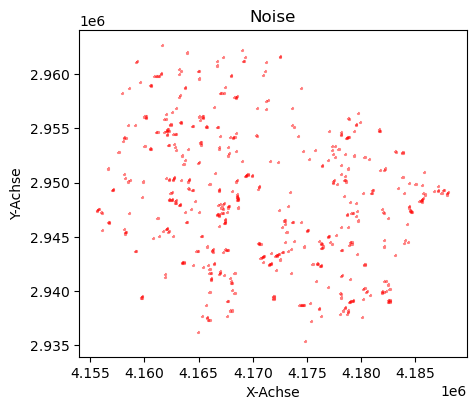

In [74]:
# Plotten der Rauschpunkte (Clusterlabel -1)
noise_points = gdf_wuerzburg[gdf_wuerzburg['cluster'] == -1]
ax = noise_points.boundary.plot(color='red', alpha=0.5, figsize=(5, 5))
plt.title('Noise')
plt.xlabel('X-Achse')
plt.ylabel('Y-Achse')
plt.show()

In [75]:
column_to_sum = 'INSGESAMT_0'
sum_of_column = noise_points[column_to_sum].sum()

print('Anzahl der Raster, die als Noise erkannt wurden: {}'.format(len(noise_points)))
print("Sum of column '{}' in noise points: {}".format(column_to_sum, sum_of_column))

Anzahl der Raster, die als Noise erkannt wurden: 563
Sum of column 'INSGESAMT_0' in noise points: 4135.0


In [76]:
# Gruppierung nach dem Cluster und Aggregierung der Punkte in jedem Cluster
cluster_summary = gdf_wuerzburg.groupby('cluster').agg(
    Gitter_ID_100m_neu=('Gitter_ID_100m_neu', 'first'),
    count=('cluster', 'size'),  # Anzahl der Polygone in jedem Cluster
    sum_INSGESAMT_0=('INSGESAMT_0', 'sum'),  
    sum_ALTER_10JG_1=('ALTER_10JG_1', 'sum'), 
    sum_ALTER_10JG_2=('ALTER_10JG_2', 'sum'), 
    sum_ALTER_10JG_3=('ALTER_10JG_3', 'sum'), 
    sum_ALTER_10JG_4=('ALTER_10JG_4', 'sum'), 
    sum_ALTER_10JG_5=('ALTER_10JG_5', 'sum'), 
    sum_ALTER_10JG_6=('ALTER_10JG_6', 'sum'), 
    sum_ALTER_10JG_7=('ALTER_10JG_7', 'sum'), 
    sum_ALTER_10JG_8=('ALTER_10JG_8', 'sum'), 
    sum_ALTER_10JG_9=('ALTER_10JG_9', 'sum'),
    sum_GESCHLECHT_1=('GESCHLECHT_1', 'sum'),
    sum_GESCHLECHT_2=('GESCHLECHT_2', 'sum'),
    crs_code=('crs_code', 'first'),
    resolution=('resolution', 'first'),
    origin_n=('origin_n', 'first'),
    origin_e=('origin_e', 'first'),
    geometry=('geometry', lambda x: unary_union(x))  # Vereinigung der Polygone in jedem Cluster
) 

# Umwandeln des aggregierten DataFrames in ein GeoDataFrame
cluster_summary_gdf = gpd.GeoDataFrame(cluster_summary, geometry='geometry', crs=gdf_wuerzburg.crs)
cluster_summary_gdf = cluster_summary_gdf.reset_index(drop=False)

In [77]:
# Funktion zur Berechnung der Entfernung zwischen zwei Punkten
def distance(point1, point2):
    return point1.distance(point2)

# Berechnung der durchschnittlichen Entfernung von jedem Polygon-Centroid zu seinen Ecken
average_distances = []
for idx, row in cluster_summary_gdf.iterrows():
    centroid = row['geometry'].centroid
    polygon = row['geometry']

    if isinstance(polygon, MultiPolygon):
        average_distance = 0  # Setzen Sie die durchschnittliche Entfernung auf 0 für Multipolygone
    else:
        # Extrahieren der Koordinaten der Polygon-Ecken
        polygon_corners = polygon.exterior.coords[:-1]  # Letzter Punkt ist der gleiche wie der erste
        # Berechnung der Entfernungen und Speichern der Ergebnisse
        distances = [distance(centroid, Point(coord)) for coord in polygon_corners]
        average_distance = sum(distances) / len(distances)
        
    average_distances.append(average_distance)

# Hinzufügen der durchschnittlichen Entfernungen als neue Spalte zum GeoDataFrame
cluster_summary_gdf['average_distance'] = average_distances

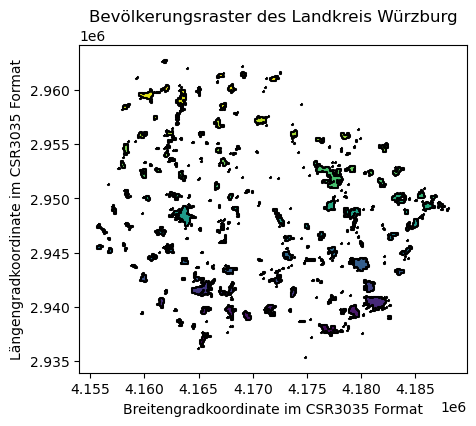

In [78]:
# Plot der Raster mit Polygone farblich darstellen
ax = cluster_summary_gdf.plot(cmap='viridis', legend=True, figsize=(5, 5))

# Hervorhebung der Rastergrenzen
cluster_summary_gdf.boundary.plot(ax=ax, color='black')

# Titel hinzufügen
plt.title('Bevölkerungsraster des Landkreis Würzburg')

# Achsenbeschriftungen hinzufügen
plt.xlabel('Breitengradkoordinate im CSR3035 Format')
plt.ylabel('Längengradkoordinate im CSR3035 Format')

plt.show()

In [79]:
# Definiere die Projektionen
in_proj = Proj(init='epsg:3035')  # CSR3035
out_proj = Proj(init='epsg:4326')  # WGS84 (Längen- und Breitengrade)

# Funktion zum Umwandeln von CSR3035-Koordinaten in Längen- und Breitengrade
def csr3035_to_latlon(polygon):
    point = polygon.centroid
    x_csr3035 = point.x
    y_csr3035 = point.y
    lon, lat = transform(in_proj, out_proj, x_csr3035, y_csr3035)
    return lon, lat

# Wende die Funktion auf die Geometry-Spalte an und erstelle neue Spalten für Längen- und Breitengrade
cluster_summary_gdf['lon'], cluster_summary_gdf['lat'] = zip(*cluster_summary_gdf['geometry'].apply(lambda point: csr3035_to_latlon(point)))

/Users/larsbuechler/anaconda3/envs/masterarbeit_python311/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/larsbuechler/anaconda3/envs/masterarbeit_python311/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/27/swfwml_s47d2057hcqghw7dh0000gn/T/ipykernel_20317/867245146.py:10: FutureWarning: This function is deprecated. See: h

In [80]:
age_group_columns = [col for col in cluster_summary_gdf.columns if col.startswith('sum_ALTER_10JG_')]

new_age_groups = { '0-10': 0,
                    '10-20': 3,
                    '20-30': 0,
                    '30-40': 0,
                    '40-50': 6,
                    '50-60': 8,
                    '60-70': 0,
                    '70-80': 9,
                    '80+': 0}

age_groups_list = list(new_age_groups.keys())


def get_age_group_data(cluster_summary_gdf):
    age_group_data = {}

    for count in range(9):
        age_group =  age_groups_list[count] # Extract age group from column name
        population = cluster_summary_gdf[age_group_columns[count]]
        age_group_data[age_group] = population
    return age_group_data


# Extract and merge age group data
age_group_data_per_cluster = cluster_summary_gdf.apply(get_age_group_data, axis=1)

cluster_summary_gdf['Alter'] = age_group_data_per_cluster

# Remove the original 'ALTER_10JG_' columns
cluster_summary_gdf.drop(columns=age_group_columns, inplace=True)

In [81]:
# Polygon Geopandas speichern
cluster_summary_gdf.to_file('./Donner_Data/cluster_donner.gpkg', driver='GPKG')